Here, we're going to explore predictive text methods based on a corpus of Trump tweets. For this, a collections of Trump's 26,560 (as of July 6, 2019) tweets has been downloaded in JSON format. These do not include retweets or extraneous information like favorites or datetimes, so the data is already pretty easy to work with. Let's start by getting our data into a dataframe using pandas.

In [30]:
import pandas as pd

In [31]:
# File is encoded with utf-8 and is a string, 
# but pandas can handle this with the .read_json method
with open('trumptweets', encoding='utf-8') as f:
    df = pd.read_json(f)

In [32]:
# Check out the df
df.head()

,text
0,....As well as we are doing from the day after...
1,"Strong jobs report, low inflation, and other c..."
2,My deepest sympathies go out to the family and...
3,Happy Birthday to our great United States @Sec...
4,"“Record 157,005,000 Employed; 19th Record of T..."


In [33]:
df.shape

(26560, 1)

In [34]:
df.iloc[0].text

'....As well as we are doing from the day after the great Election, when the Market shot right up, it could have been even better - massive additional wealth would have been created, &amp; used very well. Our most difficult problem is not our competitors, it is the Federal Reserve!'

Looks good so far. We have all the tweets loaded into our dataframe, and now we're ready to start cleaning up the data. Let's start by tokenizing the text, removing punctuation, and URLs.

In [39]:
import spacy
nlp = spacy.load('en',disable=['parser', 'tagger','ner'])

nlp.max_length = 2125923

In [36]:
# Load our ['tweets'] column into a long string format. 
tweets = ' '.join(df['text'].values.tolist())

In [37]:
# Remove URLs using regular expressions
import re
tweets = re.sub(r'^https?:\/\/.*[\r\n]*', '', tweets, flags=re.MULTILINE)

In [40]:
# Let's make a list of all the extraneous non-alpha tokens. We'll 
# use this list to remove those tokens before the learning process
removals = []
for token in nlp.tokenizer(tweets):
    if not token.text.isalpha():
        if token.text not in [',', '.', '\'', ' ','?','!', '\'s', 'n\'t']: # Note, this is a very crude way of doing this
            removals.append(token.text)
removalset = set(removals)

# Remove extraneous punctuation. 
def separate_punc(doc_text):
        return [token.text.lower() for token in nlp(doc_text) if token.text not in removalset]

tokens = separate_punc(tweets)

Now that the text has been tokenized (every token has been added to a list), we can vectorize it for input to a neural network later. Once that's complete, we can vectorize each of the tweets and begin computing conditional probabilities.

In [41]:
# Let's look at our tokens:
print(f"The first 20 tokens: {tokens[0:20]}\n")
print(f"Length of the aggregated tweets: {len(tokens)}\n")
print(f"Total number of unique tokens:  {len(set(tokens))}\n")

The first 20 tokens: ['as', 'well', 'as', 'we', 'are', 'doing', 'from', 'the', 'day', 'after', 'the', 'great', 'election', ',', 'when', 'the', 'market', 'shot', 'right', 'up']

Length of the aggregated tweets: 360035

Total number of unique tokens:  13764



In [42]:
# Organize into sequences of tokens. This gives us a line of 25 + 1 words;
# 25 for context, and then a last word for the  model to predict. In this 
# way, we have 'labeled' data to train on and validate loss during model training.

train_len = 14+1 # 10 training words , then one target word

# Empty list of sequences
text_sequences = []

for i in range(train_len, len(tokens)):
    
    # Grab train_len (# of tokens)
    seq = tokens[i-train_len:i]
    
    # Add to list of sequences
    text_sequences.append(seq)

In [44]:
# Now we need to convert these tokens to numeric values
# based on a tokenizer, and finally, vectorize them.
from keras.preprocessing.text import Tokenizer

# integer encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_sequences)
sequences = tokenizer.texts_to_sequences(text_sequences)

In [45]:
import numpy as np

sequences = np.array(sequences)

In [47]:
# Check to make sure Keras with tensorflow backend is 
# using the GPU. You can comment this out if you're 
# not using CUDA or GPU for TF. 
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

So let's check out what we've done. We've changed every token into its numeric value based on its position in the token list. Numeric IDs are unique to the token they represent. Now comes the memory-intensive stuff. We'll import Keras layers, build an LSTM neural network, and one-hot encode the entirety of our text in a giant sparse matrix that Keras can handle.

In [48]:
# Numeric representation of the text!
sequences

array([[  46,  166,   46, ...,  162,    3,   85],
       [ 166,   46,   26, ...,    3,   85,    2],
       [  46,   26,   21, ...,   85,    2,  385],
       ...,
       [ 230,    4,   31, ...,  560,   59,    2],
       [   4,   31, 5368, ...,   59,    2,   31],
       [  31, 5368, 2525, ...,    2,   31,  353]])

In [49]:
import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding

def create_model(vocabulary_size, seq_len):
    model = Sequential()
    model.add(Embedding(vocabulary_size, 25, input_length=seq_len))
    model.add(LSTM(150, return_sequences=True))
    model.add(LSTM(150))
    model.add(Dense(150, activation='relu'))

    model.add(Dense(vocabulary_size, activation='softmax'))
    
    # Normally, we'd train with categorical_crossentropy loss. However, 
    # the training data is huge. Creating a one-hot encoded matrix for 
    # all vocabulary would take nearly 40 GB of RAM. Instead, we can use
    # sparse_categorical_crossentropy to feed the model integer-value
    # labels, without the need to one-hot encode everything. The tradeoff
    # of course is that this will slow down training. 
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
   
    model.summary()
    
    return model

In [50]:
vocabulary_size = len(set(tokens))
X = sequences[:,:-1]
y = sequences[:,-1]

In [53]:
seq_len = 14
model = create_model(vocabulary_size+1, seq_len)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 14, 25)            344125    
_________________________________________________________________
lstm_5 (LSTM)                (None, 14, 150)           105600    
_________________________________________________________________
lstm_6 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dense_5 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_6 (Dense)              (None, 13765)             2078515   
Total params: 2,731,490
Trainable params: 2,731,490
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit the model 

model.fit(X, y, batch_size=1024, epochs=1100,verbose=2)

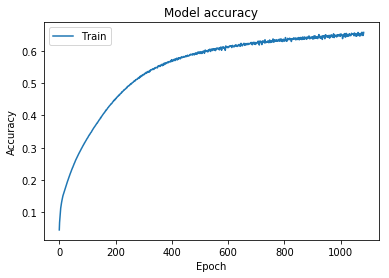

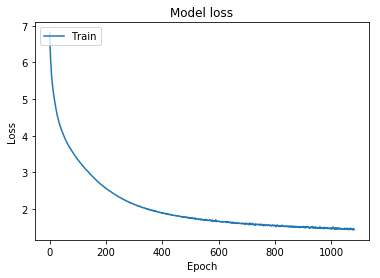

In [74]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(model.history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('acc.png', bbox_inches='tight')
plt.show()

# Plot training & validation loss values
plt.plot(model.history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.savefig('loss.png', bbox_inches='tight')

plt.show()

It looks like our model isn't going to get much better without additional preprocessing or tweaks to the density or depth of our network. Let's see what it does when we give it text to predict.

In [55]:
# Save the model for later
from pickle import dump,load

model.save('trained_model.h5')
dump(tokenizer, open('trained_model', 'wb'))

In [ ]:
# Uncomment this cell if you want to load the previously trained model

#model=load_model('trained_model.h5')
#tokenizer=load(open('trained_model','rb'))

In [59]:
# Now that we have our model trained, we'd like to start making predictive text.

from pickle import load
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences

In [69]:
def generate_text(model, tokenizer, seq_len, seed_text, num_gen_words):
    '''
    INPUTS:
    model : model that was trained on text data
    tokenizer : tokenizer that was fit on text data
    seq_len : length of training sequence
    seed_text : raw string text to serve as the seed
    num_gen_words : number of words to be generated by model
    '''
    
    # Final Output
    output_text = []
    
    # Intial Seed Sequence
    input_text = seed_text
    
    # Create num_gen_words
    for i in range(num_gen_words):
        
        # Take the input text string and encode it to a sequence
        encoded_text = tokenizer.texts_to_sequences([input_text])[0]
        
        # Pad sequences to our trained rate (50 words in the video)
        pad_encoded = pad_sequences([encoded_text], maxlen=seq_len, truncating='pre')
        
        # Predict Class Probabilities for each word
        pred_word_ind = model.predict_classes(pad_encoded, verbose=0)[0]
        
        # Grab word
        pred_word = tokenizer.index_word[pred_word_ind] 
        
        # Update the sequence of input text (shifting one over with the new word)
        input_text += ' ' + pred_word
        
        output_text.append(pred_word)
        
    # Make it look like a sentence.
    return ' '.join(output_text)

In [75]:
# Type whatever you want as seed text.
seed_text="I"

generate_text(model,tokenizer,seq_len,seed_text=seed_text,num_gen_words=15)

"also has n't have a corrupt dollar told by billion dollars worth of bin laden"

Well.... okay. Clearly we could use some more help, but there you have it!